## EHR Data Quality and Patient Flow Signals (Data Cleaning + EDA + Outlier QA)

This notebook demonstrates an end-to-end EHR data quality (QA) and preprocessing workflow prior to modelling or dashboarding. The aim is not prediction, but trustworthy data readiness for healthcare analytics, patient flow analysis, and downstream ML.

Why this matters: In healthcare, poor data quality can lead to misleading insights, unsafe decisions, and model leakage. This notebook focuses on detecting, explaining, and mitigating those risks.

#### 1. Environment & Library Imports

In [27]:
# load libraries
import pandas as pd, numpy as np, re
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

print("pandas:", pd.__version__)
print("numpy:", np.__version__)

pandas: 2.1.4
numpy: 1.26.4


#### 2. Data Loading

In [28]:
data_path = "EHR.csv"
patient_data = pd.read_csv(data_path)

# print data dims
print("Rows, columns:", patient_data.shape)

Rows, columns: (1447, 29)


### Data Dictionary
- Source: De-identified patient encounter extract  
- Unit of analysis: **Encounter-level records** (not patient-level)  
- Domain: Admissions, unit transfers, demographics, timestamps  

> ⚠️ **EHR Reality Check**  
> - Missingness often reflects workflow, not error  
> - Extreme values may be clinically meaningful  
> - Time order matters — leakage often starts here

#### 3. Data Understanding

In [30]:
# data view
patient_data.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,210014,182373,Male,45,Caucasian,73,89,"Hypertension, uncontrolled (for cerebrovascula...",178.0,13:08:59,...,Direct Admit,1,admit,116.0,112.7,15:00:00,4424,Skilled Nursing Facility,Alive,002-10665
1,200026,174624,Male,50,Caucasian,71,87,Ablation or mapping of cardiac conduction pathway,177.8,10:41:00,...,Operating Room,1,admit,106.1,106.1,17:40:00,1548,Home,Alive,002-10715
2,221131,190993,Male,83,Caucasian,71,87,"Endarterectomy, carotid",175.3,21:43:00,...,Operating Room,1,admit,NaN,72.1,17:46:00,1203,Home,Alive,002-10249
3,221215,191054,Male,49,Caucasian,71,87,"Infarction, acute myocardial (MI)",185.4,03:16:00,...,Emergency Department,1,admit,145.3,146.6,19:07:00,1562,Home,Alive,002-10627
4,217835,188445,Male,57,Caucasian,73,92,"CABG alone, coronary artery bypass grafting",172.7,01:09:00,...,Operating Room,1,admit,NaN,80.4,08:25:00,4719,Floor,Alive,002-10324


| Variable | Description | QA Considerations |
|--------|-------------|------------------|
| `age` | Patient age (string) | High ages may be censored (e.g. `> 89`) |
| `hosp_admit_time` | Hospital admission timestamp | Parsing, ordering, timezone issues |
| `unit_admit_time` | Unit admission timestamp | Enables patient flow & delay analysis |
| `gender` | Patient sex | Often missing or inconsistently coded |

In [31]:
# column names
patient_data.columns

Index(['patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age',
       'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx',
       'admissionheight', 'hospitaladmittime24', 'hospitaladmitoffset',
       'hospitaladmitsource', 'hospitaldischargeyear',
       'hospitaldischargetime24', 'hospitaldischargeoffset',
       'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype',
       'unitadmittime24', 'unitadmitsource', 'unitvisitnumber', 'unitstaytype',
       'admissionweight', 'dischargeweight', 'unitdischargetime24',
       'unitdischargeoffset', 'unitdischargelocation', 'unitdischargestatus',
       'uniquepid'],
      dtype='object')

In [32]:
# data desc
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   patientunitstayid          1447 non-null   int64  
 1   patienthealthsystemstayid  1447 non-null   int64  
 2   gender                     1444 non-null   object 
 3   age                        1446 non-null   object 
 4   ethnicity                  1405 non-null   object 
 5   hospitalid                 1447 non-null   int64  
 6   wardid                     1447 non-null   int64  
 7   apacheadmissiondx          1267 non-null   object 
 8   admissionheight            1402 non-null   float64
 9   hospitaladmittime24        1447 non-null   object 
 10  hospitaladmitoffset        1447 non-null   int64  
 11  hospitaladmitsource        1218 non-null   object 
 12  hospitaldischargeyear      1447 non-null   int64  
 13  hospitaldischargetime24    1447 non-null   objec

In [33]:
# summary stats
patient_data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
patientunitstayid,1447.0,NaN,NaN,NaN,646481.204561,385545.370181,142493.0,264749.5,421249.0,1056172.0,1135186.0
patienthealthsystemstayid,1447.0,NaN,NaN,NaN,494962.955079,269873.698956,129943.0,227611.5,359321.0,782773.5,842932.0
gender,1444,3,Female,810,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,1446,75,> 89,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ethnicity,1405,6,Caucasian,1144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hospitalid,1447.0,NaN,NaN,NaN,139.385625,52.179555,69.0,92.0,112.0,194.0,199.0
wardid,1447.0,NaN,NaN,NaN,301.238424,158.898758,85.0,136.0,252.0,467.0,495.0
apacheadmissiondx,1267,197,"Sepsis, pulmonary",83,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admissionheight,1402.0,NaN,NaN,NaN,168.061591,13.442189,1.6,160.0,167.6,177.8,297.18
hospitaladmittime24,1447,842,00:20:00,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# check duplicates
patient_data.duplicated().sum()

0

We begin by inspecting:
- Dataset shape
- Data types
- Sample rows
- Presence of critical variables

### Required columns and rationale
The following fields are required for downstream analysis:
- `age`: demographic stratification
- `hosp_admit_time`: index time for patient flow
- `unit_admit_time`: enables transfer timing analysis

Rows missing these fields were removed to preserve analytic validity.

#### 4. Missingness & Data Quality

<Axes: >

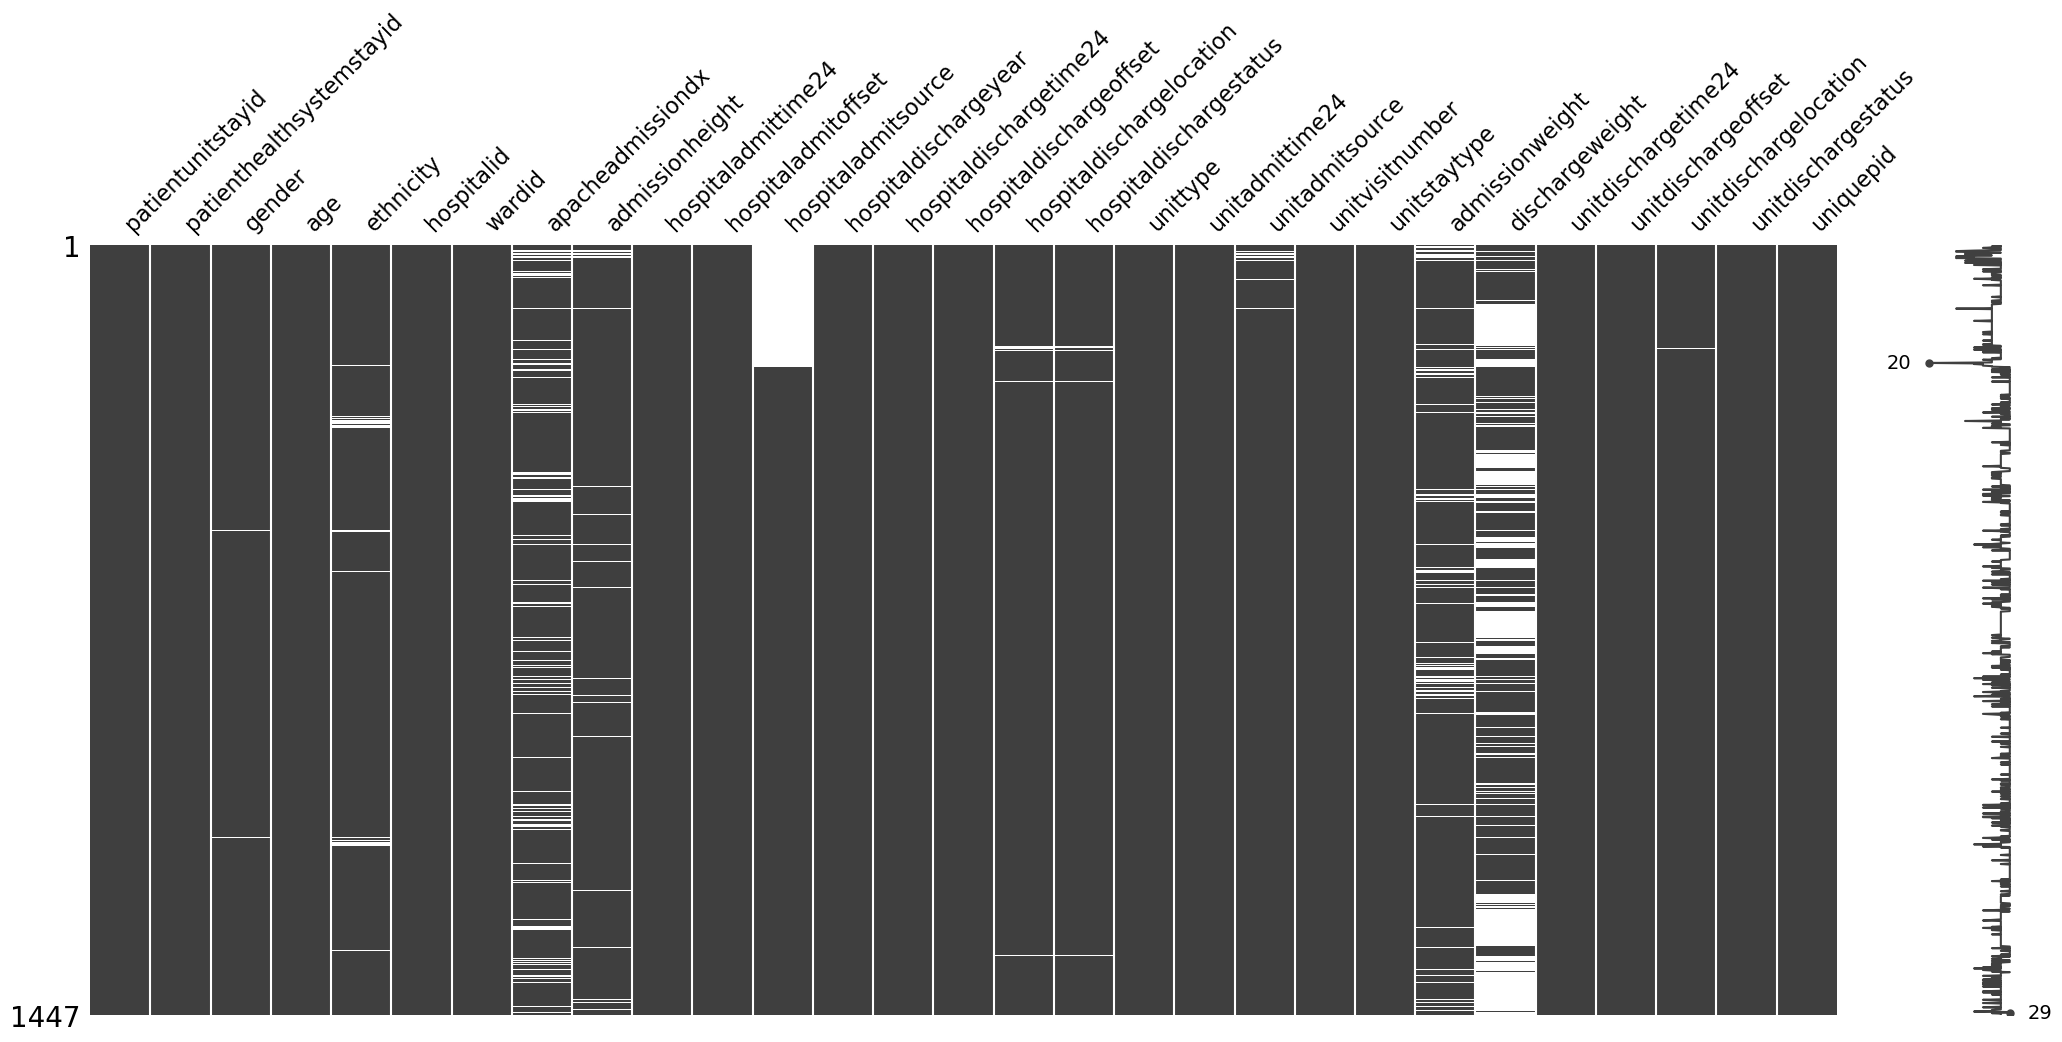

In [39]:
# view missing values
missing = patient_data.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(patient_data) * 100).round(2)
pd.DataFrame({"missing": missing, "missing_%": missing_pct}).query("missing > 0")
msno.matrix(patient_data)

**Quantitative Missingness Summary**
For each column, missing values are assessed using:
- Absolute counts
- Percentage missing

This helps identify fields that may bias analysis or require imputation.

**Visual Missingness Matrix**
A missingness matrix is used to:
- Detect systematic patterns
- Identify workflow-driven gaps
- Avoid treating missingness as random noise

**Interpretation:**
- High missingness in demographics may reflect emergency admissions
- Time-related missingness often indicates incomplete transfer documentation

In [7]:
# missing values analysis
patient_data.isna().sum().sort_values(ascending=False)

dischargeweight              576
hospitaladmitsource          229
apacheadmissiondx            180
admissionweight              134
admissionheight               45
ethnicity                     42
unitadmitsource               19
hospitaldischargelocation      8
hospitaldischargestatus        7
unitdischargelocation          5
gender                         3
unitdischargestatus            2
age                            1
patientunitstayid              0
unitdischargeoffset            0
unitstaytype                   0
unitdischargetime24            0
unitvisitnumber                0
hospitaldischargeoffset        0
unitadmittime24                0
unittype                       0
patienthealthsystemstayid      0
hospitaldischargetime24        0
hospitaldischargeyear          0
hospitaladmitoffset            0
hospitaladmittime24            0
wardid                         0
hospitalid                     0
uniquepid                      0
dtype: int64

#### 5. Cleaning Strategy

Dropping missing values blindly is risky in healthcare, so do not just drop them without explaining why. Always add a choice structure:
- **Option A**: drop rows if missingness is low and random
- **Option B**: impute for selected fields
- **Option C**: keep NaNs but flag “missing indicator” features

**Note**: For this tutorial, we drop rows with missing values in the minimum required columns only.

In [40]:
required_cols = ["age", "hospitaladmittime24", "unitadmittime24"]
patient_data_cleaned = patient_data.dropna(subset=required_cols).copy()
patient_data_cleaned.shape

(1446, 29)

#### 6. Feature Engineering

In [49]:
def clean_age(x):
    if pd.isna(x): 
        return np.nan
    s = str(x).strip()
    if s.startswith(">"):
        digits = re.findall(r"\d+", s)
        return int(digits[0]) + 1 if digits else np.nan
    digits = re.findall(r"\d+", s)
    return int(digits[0]) if digits else np.nan

def extract_hour(time_str):
    if pd.isna(time_str):
        return np.nan
    s = str(time_str).strip()
    m = re.match(r"^(\d{1,2}):(\d{2})(?::(\d{2}))?$", s)
    return float(m.group(1)) if m else np.nan

patient_data_cleaned["age_num"] = patient_data_cleaned["age"].apply(clean_age)
patient_data_cleaned["hosp_admit_hour"] = patient_data_cleaned["hospitaladmittime24"].apply(extract_hour)
patient_data_cleaned["unit_admit_hour"] = patient_data_cleaned["unitadmittime24"].apply(extract_hour)

patient_data_cleaned[["age", "age_num", "hospitaladmittime24", "hosp_admit_hour"]].sample(10)

,age,age_num,hospitaladmittime24,hosp_admit_hour
2,83,83,21:43:00,21.0
674,58,58,10:45:00,10.0
1127,> 89,90,03:46:00,3.0
155,46,46,16:04:00,16.0
1407,44,44,15:58:00,15.0
558,74,74,12:22:00,12.0
1158,50,50,11:29:00,11.0
741,78,78,01:55:00,1.0
173,58,58,00:36:00,0.0
1047,35,35,18:50:00,18.0


#### Age Cleaning
Healthcare datasets often censor high ages for privacy reasons (e.g. `> 89`).

**Approach:**
- Convert censored age values to numeric upper bounds
- Preserve analytical usability while respecting governance constraints

**Before vs After Example:**

| Raw Age | Cleaned Age |
|--------|-------------|
| `> 89` | 90 |
| `45` | 45 |

#### Time Feature Extraction
Admission timestamps are parsed and transformed to extract:
- Hour of day

**Why this matters:**
- Identifies peak admission periods
- Supports staffing, capacity, and operational planning

#### Future Feature Extensions
- Admission delay (`unit_admit_time - hosp_admit_time`)
- Night vs day admission flags
- Weekday vs weekend indicators

#### 7. Exploratory Analysis

In [50]:
# summary stats - numerical summary
patient_data_cleaned.describe()

,patientunitstayid,patienthealthsystemstayid,hospitalid,wardid,admissionheight,hospitaladmitoffset,hospitaldischargeyear,hospitaldischargeoffset,unitvisitnumber,admissionweight,dischargeweight,unitdischargeoffset,age_num,hosp_admit_hour,unit_admit_hour
count,1.446000e+03,1446.000000,1446.000000,1446.000000,1402.000000,1446.000000,1446.000000,1446.000000,1446.000000,1313.000000,871.000000,1446.000000,1446.000000,1446.000000,1446.000000
mean,6.466697e+05,495083.587828,139.404564,301.272476,168.061591,-2134.494467,2014.652144,8534.878285,1.186722,82.985773,84.457991,3841.501383,65.285615,12.210927,12.489627
std,3.856120e+05,269928.035473,52.192632,158.948449,13.442189,8501.011983,0.476455,9781.989044,0.477584,24.965156,25.173490,5895.644838,16.499241,7.392537,7.636524
min,1.424930e+05,129943.000000,69.000000,85.000000,1.600000,-251404.000000,2014.000000,-62.000000,1.000000,10.000000,35.100000,0.000000,16.000000,0.000000,0.000000
25%,2.647432e+05,227606.250000,92.000000,136.000000,160.000000,-1523.500000,2014.000000,2747.000000,1.000000,65.700000,67.155000,1272.500000,55.000000,5.000000,5.000000
50%,6.903360e+05,532710.000000,146.500000,338.000000,167.600000,-221.500000,2015.000000,5715.000000,1.000000,78.100000,80.030000,2363.000000,67.000000,14.000000,14.000000
75%,1.056226e+06,782821.250000,194.000000,467.000000,177.800000,-43.250000,2015.000000,10208.250000,1.000000,97.700000,99.650000,4305.000000,78.000000,19.000000,19.000000
max,1.135186e+06,842932.000000,199.000000,495.000000,297.180000,4031.000000,2015.000000,133974.000000,5.000000,262.400000,249.800000,119276.000000,90.000000,23.000000,23.000000


In [55]:
# Identify categorical columns
categorical_cols = patient_data_cleaned.select_dtypes(include=['object', 'category']).columns

# Value counts for each categorical column
for col in categorical_cols:
    print(f"\n{col} (top 10):")
    display(patient_data_cleaned[col].value_counts().head(10))


gender (top 10):


gender
Female     810
Male       632
Unknown      2
Name: count, dtype: int64


age (top 10):


age
> 89    64
78      60
77      46
67      44
58      41
68      40
76      39
70      38
56      34
59      34
Name: count, dtype: int64


ethnicity (top 10):


ethnicity
Caucasian           1144
African American     162
Other/Unknown         43
Native American       29
Asian                 20
Hispanic               7
Name: count, dtype: int64


apacheadmissiondx (top 10):


apacheadmissiondx
Sepsis, pulmonary                                                                      83
CHF, congestive heart failure                                                          57
Rhythm disturbance (atrial, supraventricular)                                          54
Infarction, acute myocardial (MI)                                                      46
Angina, unstable (angina interferes w/quality of life or meds are tolerated poorly)    35
Sepsis, renal/UTI (including bladder)                                                  34
CVA, cerebrovascular accident/stroke                                                   34
Bleeding, GI-location unknown                                                          33
Diabetic ketoacidosis                                                                  31
CABG alone, coronary artery bypass grafting                                            29
Name: count, dtype: int64


hospitaladmittime24 (top 10):


hospitaladmittime24
00:20:00    8
19:19:00    7
20:55:00    7
02:01:00    6
06:30:00    6
06:00:00    6
03:30:00    6
12:38:00    5
07:03:00    5
17:55:00    5
Name: count, dtype: int64


hospitaladmitsource (top 10):


hospitaladmitsource
Emergency Department    670
Floor                   222
Operating Room          138
Direct Admit            116
Recovery Room            37
Other Hospital           23
Step-Down Unit (SDU)      9
ICU to SDU                2
Other ICU                 1
Name: count, dtype: int64


hospitaldischargetime24 (top 10):


hospitaldischargetime24
21:15:00    18
18:00:00    17
20:40:00    16
19:00:00    16
17:30:00    15
19:30:00    15
20:00:00    14
21:00:00    13
23:30:00    12
21:30:00    11
Name: count, dtype: int64


hospitaldischargelocation (top 10):


hospitaldischargelocation
Home                        801
Skilled Nursing Facility    204
Other Hospital              128
Death                       121
Other                        69
Rehabilitation               54
Other External               46
Nursing Home                 15
Name: count, dtype: int64


hospitaldischargestatus (top 10):


hospitaldischargestatus
Alive      1318
Expired     121
Name: count, dtype: int64


unittype (top 10):


unittype
Med-Surg ICU    968
MICU            118
CTICU           114
Cardiac ICU      74
CCU-CTICU        56
Neuro ICU        51
SICU             43
CSICU            22
Name: count, dtype: int64


unitadmittime24 (top 10):


unitadmittime24
19:00:00    6
19:38:00    6
19:12:00    5
18:28:00    5
23:21:00    5
16:31:00    5
22:17:00    5
13:40:00    4
04:00:00    4
16:47:00    4
Name: count, dtype: int64


unitadmitsource (top 10):


unitadmitsource
Emergency Department    660
Floor                   252
Operating Room          165
ICU to SDU              123
Direct Admit            115
Recovery Room            40
Other Hospital           29
Step-Down Unit (SDU)     27
Other ICU                16
ICU                       1
Name: count, dtype: int64


unitstaytype (top 10):


unitstaytype
admit             1198
stepdown/other     155
readmit             61
transfer            32
Name: count, dtype: int64


unitdischargetime24 (top 10):


unitdischargetime24
17:39:00    8
19:12:00    7
18:06:00    7
21:35:00    7
21:26:00    7
15:00:00    6
20:30:00    6
16:00:00    6
17:43:00    6
18:15:00    6
Name: count, dtype: int64


unitdischargelocation (top 10):


unitdischargelocation
Floor                       815
Home                        168
Step-Down Unit (SDU)        147
Other Hospital               82
Death                        72
Telemetry                    63
Other ICU                    35
Skilled Nursing Facility     23
Other External               13
Other                        11
Name: count, dtype: int64


unitdischargestatus (top 10):


unitdischargestatus
Alive      1372
Expired      72
Name: count, dtype: int64


uniquepid (top 10):


uniquepid
004-12287    10
002-15638    10
002-10665     5
002-1043      5
003-43270     5
003-10109     5
010-10380     5
010-10222     4
004-1255      4
009-10231     4
Name: count, dtype: int64

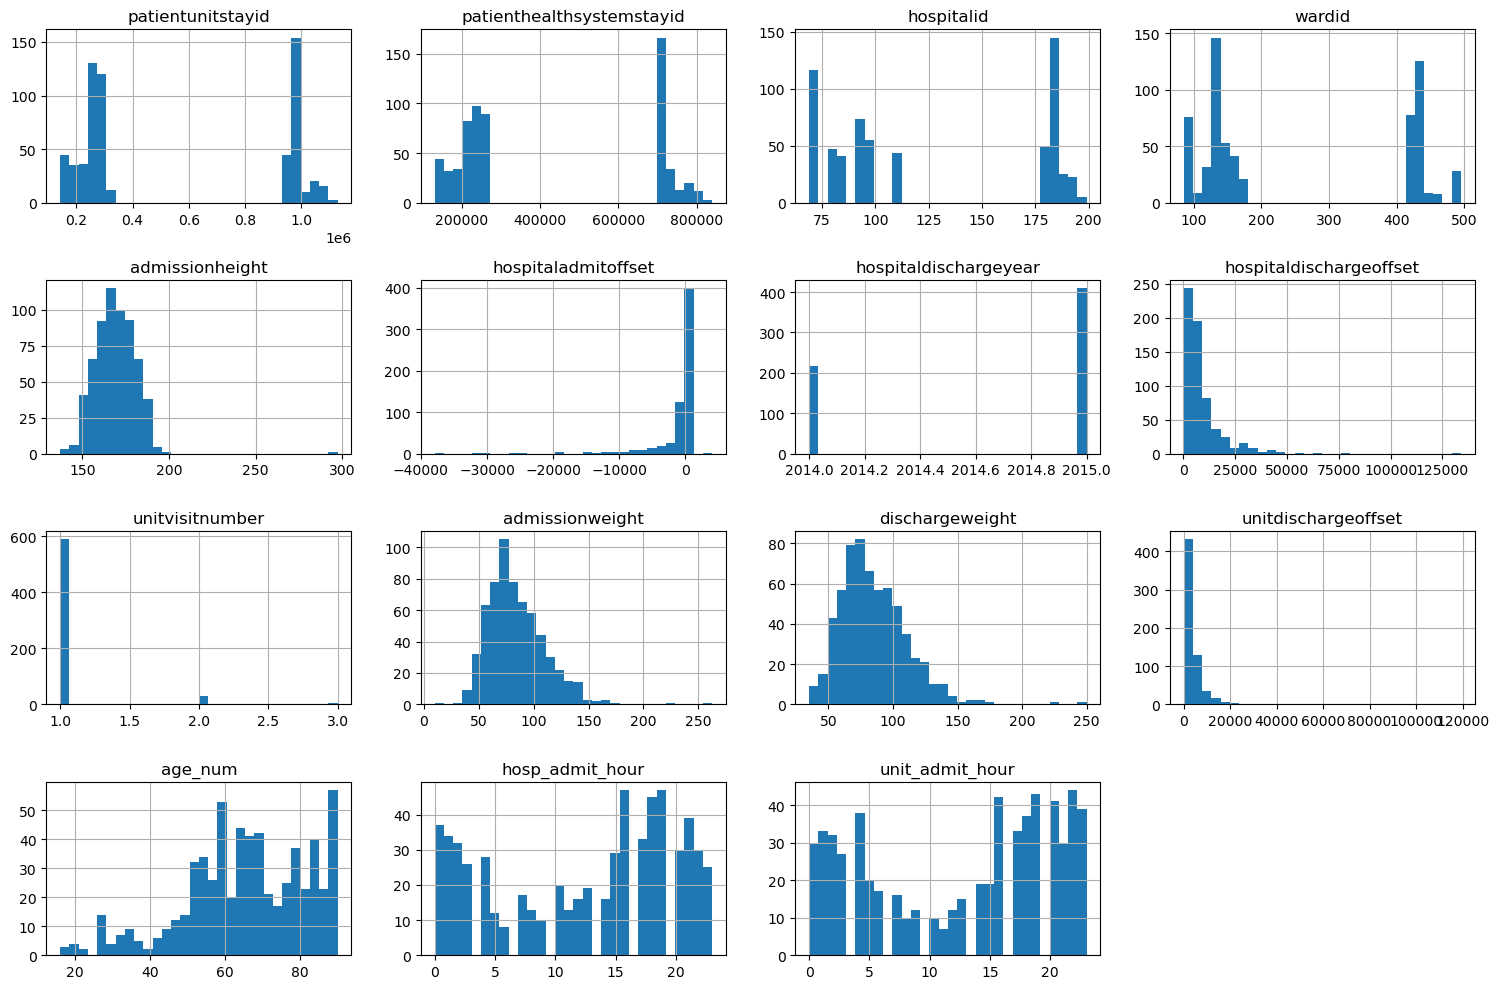

In [18]:
# Select numerical columns
numerical_cols = patient_data_cleaned.select_dtypes(include=[np.number]).columns

# Histograms for all numerical columns
patient_data_cleaned[numerical_cols].hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

In [20]:
# Correlation matrix for numerical data
correlation_matrix = patient_data_cleaned[numerical_cols].corr()
correlation_matrix

,patientunitstayid,patienthealthsystemstayid,hospitalid,wardid,admissionheight,hospitaladmitoffset,hospitaldischargeyear,hospitaldischargeoffset,unitvisitnumber,admissionweight,dischargeweight,unitdischargeoffset,age_num,hosp_admit_hour,unit_admit_hour
patientunitstayid,1.000000,0.999775,0.988703,0.996186,-0.208631,-0.149934,0.337706,0.122786,0.137514,-0.138509,-0.157678,0.075942,0.148400,-0.051784,0.010575
patienthealthsystemstayid,0.999775,1.000000,0.988847,0.995713,-0.206373,-0.149855,0.334033,0.122046,0.137821,-0.137285,-0.156339,0.074736,0.148139,-0.051909,0.010182
hospitalid,0.988703,0.988847,1.000000,0.986926,-0.210805,-0.148548,0.330796,0.112688,0.133319,-0.141495,-0.161199,0.070973,0.176142,-0.051038,0.013488
wardid,0.996186,0.995713,0.986926,1.000000,-0.213855,-0.147685,0.331570,0.119312,0.133657,-0.136188,-0.154069,0.077735,0.150848,-0.046354,0.014812
admissionheight,-0.208631,-0.206373,-0.210805,-0.213855,1.000000,-0.024938,-0.086919,0.044014,0.016340,0.365895,0.369811,0.042540,-0.193762,-0.029091,-0.053182
hospitaladmitoffset,-0.149934,-0.149855,-0.148548,-0.147685,-0.024938,1.000000,-0.008695,-0.172614,-0.472559,-0.034016,-0.024637,-0.097981,-0.028628,0.013001,-0.034362
hospitaldischargeyear,0.337706,0.334033,0.330796,0.331570,-0.086919,-0.008695,1.000000,-0.004294,0.033827,-0.090944,-0.092953,-0.009511,0.120348,-0.015810,-0.036459
hospitaldischargeoffset,0.122786,0.122046,0.112688,0.119312,0.044014,-0.172614,-0.004294,1.000000,0.119247,0.004710,-0.007835,0.735722,0.002922,0.005989,0.000215
unitvisitnumber,0.137514,0.137821,0.133319,0.133657,0.016340,-0.472559,0.033827,0.119247,1.000000,-0.026795,-0.024501,0.084266,-0.021077,-0.001597,0.036696
admissionweight,-0.138509,-0.137285,-0.141495,-0.136188,0.365895,-0.034016,-0.090944,0.004710,-0.026795,1.000000,0.934154,0.031673,-0.214802,0.002624,0.026005


#### Distributions
We examine:
- Age distribution
- Admission hour patterns

These provide an initial sense of population structure and operational flow.

#### Correlation Analysis
A correlation matrix is generated to explore relationships between numeric features.

**Key observations:**
- Expected: Age shows weak association with admission timing
- Surprising: Time-of-day patterns appear independent of demographics
- Implication: Patient flow drivers may be operational rather than patient-driven

#### 8. Outlier QA

In [79]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Get numerical columns (excluding IDs)
id_columns = ['patientunitstayid', 'patienthealthsystemstayid', 'hospitalid', 'wardid']
numerical_cols = [col for col in patient_data_cleaned.select_dtypes(include=[np.number]).columns 
                  if col not in id_columns]

# Create summary dataframe
outlier_summary = []

for col in numerical_cols:
    outliers, lower, upper = detect_outliers_iqr(patient_data_cleaned, col)
    
    outlier_summary.append({
        'Column': col,
        'Outliers': len(outliers),
        'Outliers_%': round((len(outliers) / len(patient_data_cleaned)) * 100, 2),
        'Lower': lower,
        'Upper': upper
    })

# Display summary
outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df.sort_values('Outliers_%', ascending=False)
outlier_df

,Column,Outliers,Outliers_%,Lower,Upper
4,unitvisitnumber,225,15.56,1.0000,1.0000
1,hospitaladmitoffset,213,14.73,-3743.8750,2177.1250
7,unitdischargeoffset,120,8.30,-3276.2500,8853.7500
3,hospitaldischargeoffset,113,7.81,-8444.8750,21400.1250
5,admissionweight,23,1.59,17.7000,145.7000
8,age_num,13,0.90,20.5000,112.5000
6,dischargeweight,12,0.83,18.4125,148.3925
0,admissionheight,7,0.48,133.3000,204.5000
2,hospitaldischargeyear,0,0.00,2012.5000,2016.5000
9,hosp_admit_hour,0,0.00,-16.0000,40.0000


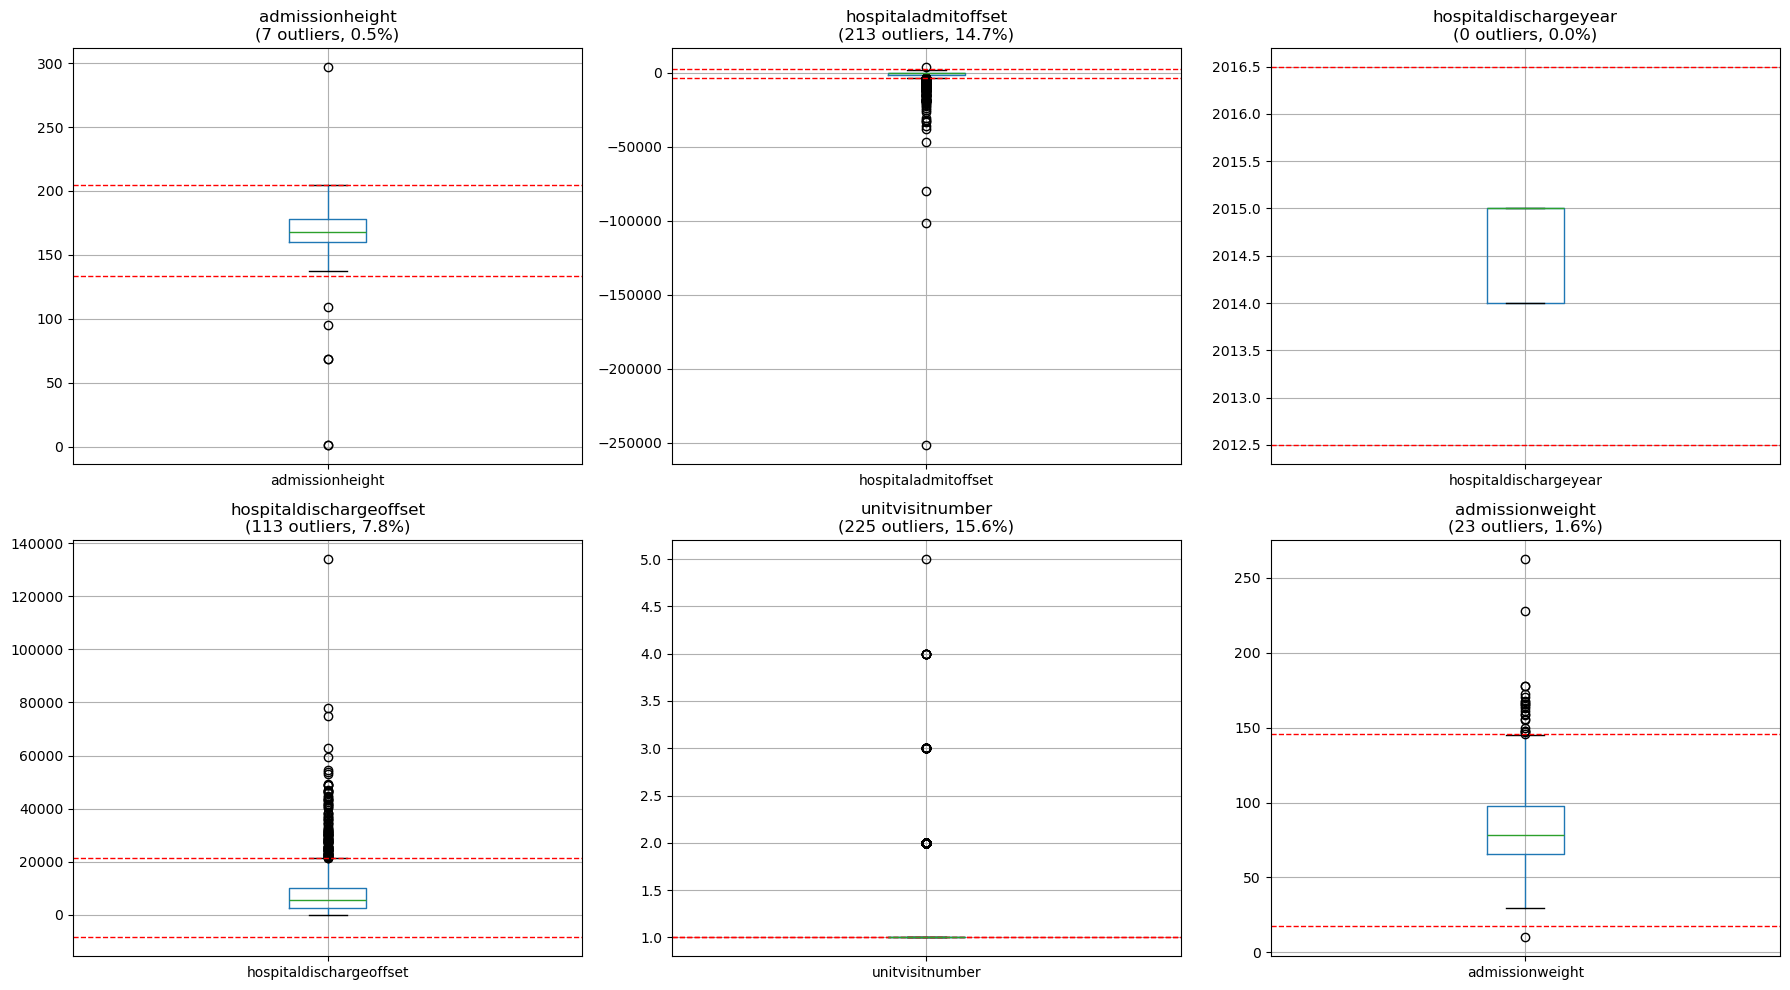

In [65]:
# Visualise outliers for top 6 columns only
top_6_cols = numerical_cols[:6]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(top_6_cols):
    patient_data_cleaned.boxplot(column=col, ax=axes[i])
    
    outliers, lower, upper = detect_outliers_iqr(patient_data_cleaned, col)
    axes[i].set_title(f'{col}\n({len(outliers)} outliers, {(len(outliers)/len(patient_data_cleaned)*100):.1f}%)')
    axes[i].axhline(y=lower, color='r', linestyle='--', linewidth=1, label='Lower')
    axes[i].axhline(y=upper, color='r', linestyle='--', linewidth=1, label='Upper')

plt.tight_layout()
plt.show()

#### Outlier Detection (QA-Focused)
Outliers are identified using the **Interquartile Range (IQR) method**.

> ⚠️ **Important clinical note:**  
> Outliers are **not automatically removed**.  
> In healthcare data, extreme values may reflect clinical deterioration or acuity rather than data error.

Outliers are flagged for review, not deletion.

#### Reusable QA Summary Function
A consolidated QA function is implemented to generate:
- Missingness overview
- Descriptive statistics
- Outlier counts

**Note**: This simulates a **production-ready QA report** that can be reused across multiple healthcare datasets.

#### Comprehensive Summary Function

In [77]:
def data_summary(df):
    print("="*100)
    print("DATASET SUMMARY")
    print("="*100)

    print(f"\n1) Shape: {df.shape[0]} rows x {df.shape[1]} columns")
    print("\n2) Column Types:")
    print(df.dtypes.value_counts())

    print("\n3) Missing Values (top 15):")
    missing = df.isnull().sum().sort_values(ascending=False)
    missing_pct = (missing / len(df) * 100).round(2)
    display(pd.DataFrame({"missing": missing, "missing_%": missing_pct}).query("missing > 0").head(15))

    print(f"\n4) Duplicates: {df.duplicated().sum()}")

    print("\n5) Numerical Summary:")
    display(df.describe().T)

    print("\n6) Categorical Columns (top 5 categories each):")
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        display(df[col].value_counts().head(5))

data_summary(patient_data_cleaned)

DATASET SUMMARY

1) Shape: 1446 rows x 32 columns

2) Column Types:
object     17
int64      10
float64     5
Name: count, dtype: int64

3) Missing Values (top 15):


,missing,missing_%
dischargeweight,575,39.76
hospitaladmitsource,228,15.77
apacheadmissiondx,179,12.38
admissionweight,133,9.20
admissionheight,44,3.04
ethnicity,41,2.84
unitadmitsource,18,1.24
hospitaldischargelocation,8,0.55
hospitaldischargestatus,7,0.48
unitdischargelocation,5,0.35



4) Duplicates: 0

5) Numerical Summary:


,count,mean,std,min,25%,50%,75%,max
patientunitstayid,1446.0,646669.724066,385612.032677,142493.0,264743.250,690336.00,1056226.50,1135186.00
patienthealthsystemstayid,1446.0,495083.587828,269928.035473,129943.0,227606.250,532710.00,782821.25,842932.00
hospitalid,1446.0,139.404564,52.192632,69.0,92.000,146.50,194.00,199.00
wardid,1446.0,301.272476,158.948449,85.0,136.000,338.00,467.00,495.00
admissionheight,1402.0,168.061591,13.442189,1.6,160.000,167.60,177.80,297.18
hospitaladmitoffset,1446.0,-2134.494467,8501.011983,-251404.0,-1523.500,-221.50,-43.25,4031.00
hospitaldischargeyear,1446.0,2014.652144,0.476455,2014.0,2014.000,2015.00,2015.00,2015.00
hospitaldischargeoffset,1446.0,8534.878285,9781.989044,-62.0,2747.000,5715.00,10208.25,133974.00
unitvisitnumber,1446.0,1.186722,0.477584,1.0,1.000,1.00,1.00,5.00
admissionweight,1313.0,82.985773,24.965156,10.0,65.700,78.10,97.70,262.40



6) Categorical Columns (top 5 categories each):


gender
Female     810
Male       632
Unknown      2
Name: count, dtype: int64

age
> 89    64
78      60
77      46
67      44
58      41
Name: count, dtype: int64

ethnicity
Caucasian           1144
African American     162
Other/Unknown         43
Native American       29
Asian                 20
Name: count, dtype: int64

apacheadmissiondx
Sepsis, pulmonary                                                                      83
CHF, congestive heart failure                                                          57
Rhythm disturbance (atrial, supraventricular)                                          54
Infarction, acute myocardial (MI)                                                      46
Angina, unstable (angina interferes w/quality of life or meds are tolerated poorly)    35
Name: count, dtype: int64

hospitaladmittime24
00:20:00    8
19:19:00    7
20:55:00    7
02:01:00    6
06:30:00    6
Name: count, dtype: int64

hospitaladmitsource
Emergency Department    670
Floor                   222
Operating Room          138
Direct Admit            116
Recovery Room            37
Name: count, dtype: int64

hospitaldischargetime24
21:15:00    18
18:00:00    17
20:40:00    16
19:00:00    16
17:30:00    15
Name: count, dtype: int64

hospitaldischargelocation
Home                        801
Skilled Nursing Facility    204
Other Hospital              128
Death                       121
Other                        69
Name: count, dtype: int64

hospitaldischargestatus
Alive      1318
Expired     121
Name: count, dtype: int64

unittype
Med-Surg ICU    968
MICU            118
CTICU           114
Cardiac ICU      74
CCU-CTICU        56
Name: count, dtype: int64

unitadmittime24
19:00:00    6
19:38:00    6
19:12:00    5
18:28:00    5
23:21:00    5
Name: count, dtype: int64

unitadmitsource
Emergency Department    660
Floor                   252
Operating Room          165
ICU to SDU              123
Direct Admit            115
Name: count, dtype: int64

unitstaytype
admit             1198
stepdown/other     155
readmit             61
transfer            32
Name: count, dtype: int64

unitdischargetime24
17:39:00    8
19:12:00    7
18:06:00    7
21:35:00    7
21:26:00    7
Name: count, dtype: int64

unitdischargelocation
Floor                   815
Home                    168
Step-Down Unit (SDU)    147
Other Hospital           82
Death                    72
Name: count, dtype: int64

unitdischargestatus
Alive      1372
Expired      72
Name: count, dtype: int64

uniquepid
004-12287    10
002-15638    10
002-10665     5
002-1043      5
003-43270     5
Name: count, dtype: int64

#### Key Findings
- EHR data quality issues are systematic, not random
- Age and time fields require domain-aware cleaning
- QA must precede modelling to avoid leakage and false confidence

#### Next Steps
- Patient-level aggregation
- Length-of-stay modelling
- Integration with temporal leakage checks and governance rules